**Vector Quantizer Variational AutoEncoder** is a powerful generative model that learns such **discrete representations**. It can be utils in mucic generator, image generator, SpeechToText, OCR....

In this Notebook I will start with the very Basics VQ-VAE. mnist data for study.
I have learn a lot from these ressources : 

article : 
https://arxiv.org/abs/1711.00937v2

code :
https://keras.io/examples/generative/vq_vae/
https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py
https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=B4CzjBuPDv8m
(thanks a lot !)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
import matplotlib.pyplot as plt

import IPython.display as ipd
import IPython
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import os

In [4]:
#data_dir = '../input/chinese-mnist/data/data'
#classes = os.listdir(data_dir)

In [5]:
#classes
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
print(x_train.shape)

(60000, 28, 28, 1)


In [7]:
class VectorQuantizerEMA(layers.Layer):
    def __init__(self, embedding_dim, num_embeddings, beta=0.25, decay=0.99,epsilon=1e-5,  name="vector_quantizer", **kwarg):
        super().__init__(**kwarg)
        self.embedding_dim=embedding_dim
        self.num_embeddings=num_embeddings
        self.beta=beta
        self.decay=decay
        self.epsilon=epsilon
        self._commitment_cost=beta
       
        
        w_init=tf.initializers.VarianceScaling(distribution='uniform') 
        #w_init=tf.initializers.RandomUniform(minval=-1/self.num_embeddings, maxval=1/self.num_embeddings)
        self.embedding=tf.Variable(
            initial_value=w_init(shape=(self.embedding_dim, self.num_embeddings), dtype='float32'),
            trainable=False,
            name='embedding_vqvae')
        
        self._ema_cluster_size=tf.zeros(shape=[num_embeddings])
        self._ema_w=tf.Variable(initial_value=self.embedding.read_value(),trainable=False)
        
    def call(self, x, training=True):
            
            
            input_shape=tf.shape(x)#B,H,W,C=D
            flat_input=tf.reshape(x, [-1, self.embedding_dim])
            
            similarity=tf.matmul(flat_input, self.embedding)
            
            distances=tf.reduce_sum(flat_input**2, axis=1, keepdims=True)-2*similarity+tf.reduce_sum(self.embedding**2, axis=0, keepdims=True)
                    
            encoding_indices=tf.argmin(distances,axis=1)
            encodings=tf.one_hot(encoding_indices, depth=self.num_embeddings)
            encoding_indices=tf.reshape(encoding_indices, input_shape[:-1])
            quantized=self.quantize(encoding_indices)
            
            e_latent_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)#A VERIFIER flat_input
            
             # Use EMA to update the embedding vectors
            if training:
                 
                
                self._ema_cluster_size = self._ema_cluster_size * self.decay + \
                                     (1 - self.decay) * tf.reduce_sum(encodings, 0)
                #encodings-->(BHW,num_embed)
                # flat_input-->(BHW, D)
                sum_per_clu_in_batch=tf.matmul(flat_input,encodings, transpose_a=True)
                
                self._ema_w=self._ema_w*self.decay+(1-self.decay)*sum_per_clu_in_batch
                #self._ema_w-->(D, num_embed)
                #self._ema_cluster_size-->(num_embed)
                
                # Laplace smoothing of the cluster size (avoid divided by zero)
                n=tf.reduce_sum(self._ema_cluster_size)#normaly n --> B*H*W
                
                self._ema_cluster_size = (self._ema_cluster_size+self.epsilon)*n/(n+self.num_embeddings*self.epsilon)
                
                normalised_updated_ema_w=self._ema_w/self._ema_cluster_size#tf.reshape[1,-1]
                
                
                with tf.control_dependencies(control_inputs=[e_latent_loss]):#unnecessary in tf2
                    
                    update_w = self.embedding.assign(normalised_updated_ema_w)
                    with tf.control_dependencies([update_w]):
                          loss = self._commitment_cost * e_latent_loss
            else:
                loss = self._commitment_cost * e_latent_loss
            
            quantized = x + tf.stop_gradient(quantized - x)#quantized but gradient(x)
            avg_probs = tf.reduce_mean(encodings, 0)
            perplexity = tf.exp(- tf.reduce_sum(avg_probs * tf.math.log(avg_probs + 1e-10)))

            return {'quantize': quantized,
                    'loss': loss,
                    'perplexity': perplexity,
                    'encodings': encodings,
                    'encoding_indices': encoding_indices}
            
        
        
        
    def quantize(self, encoding_indices):
            """
            return : 
                matrix dim (B*H*W, dim_embedding)
                les vecteurs (de dimension dim_embedding) de l'embedding correspondant aux numéros de la modalisation discrète
            note :
                Ici, on évite le produit matricielle avec ohe "encodings": plus direct avec les indices"""
            w = tf.transpose(self.embedding, [1, 0])
            return tf.nn.embedding_lookup(w, encoding_indices)
                    
            
            
            

In [8]:
class Residual_1D(layers.Layer):
    def __init__(self, filters_out, filters_hidden, kernel_size=3,  **args):
        super().__init__(**args)
        self.kernel_size=kernel_size
        self.filters_out=filters_out
        self.filters_hidden=16#filters_hidden
        print(self.kernel_size,self.filters_out,self.filters_hidden)
    def build(self, input_shape):
        self.kernel_size=input_shape[1]
        self.conv1=tf.keras.layers.Conv2D(filters=self.filters_hidden, kernel_size=self.kernel_size, strides=1, padding='same')
        self.conv2=tf.keras.layers.Conv2D(filters=self.filters_out, kernel_size=self.kernel_size, strides=1, padding='same')
        
        
    def call(self, inputs):
        x=tf.nn.relu(inputs)
        x=self.conv1(x)
        x=tf.nn.relu(x)
        x=self.conv2(x)
        return x + inputs

In [9]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, out_channel, **kargs):
        super().__init__(**kargs)
        self.out_channel=out_channel
    def build(self, input_shape):
        
        self.kernel_size_in=4
        self.hidden_dim=input_shape[1]-(self.kernel_size_in-1)
        
        self.conv1=tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same')#(BS,14 )
        self.conv2=tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same')
        self.conv3=tf.keras.layers.Conv2D(filters=self.out_channel, kernel_size=1, strides=1, padding='same')
        
    def call(self, inputs):
        x=self.conv1(inputs)
        x=tf.nn.relu(x)
        x=self.conv2(x)
        x=tf.nn.relu(x)
        return self.conv3(x)
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self,out_channel, out_dim, **kwargs):
        super().__init__(**kwargs)
        self.out_channel=out_channel
        self.out_dim=out_dim
    def build(self, input_shape):
        self.in_channel=input_shape[-1]
        self.conv_trans_1=tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')#(BS, )
        self.conv_trans_2=tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')
        self.conv_trans_3=tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')
        
    def call(self, inputs):
        
        x=self.conv_trans_1(inputs)
        x=tf.nn.relu(x)
        x=self.conv_trans_2(x)
        x=tf.nn.relu(x)
        x=self.conv_trans_3(x)
        x=tf.nn.tanh(x)*0.5
        return x
       

In [10]:
class VQVAE(tf.keras.Model):
    def __init__(self,embedding_dim=8, num_embeddings=32, **kwargs):#train_variance=None,, embedding_dim=32,
        super().__init__(**kwargs)
        
        self.num_embeddings=num_embeddings
        self.embedding_dim=embedding_dim
        
    def build(self, input_shape):
        
        self.encoder=Encoder(self.embedding_dim)
        self.vectorquantizer=VectorQuantizerEMA(embedding_dim=self.embedding_dim, num_embeddings=self.num_embeddings, name="vector_quantizer")
        self.decoder=Decoder(out_channel=input_shape[-1], out_dim=input_shape[1])
        
    def call(self, x):
        z=self.encoder(x)
        dict_vq=self.vectorquantizer(z)
        x_recon=self.decoder(dict_vq['quantize'])
        return x_recon, dict_vq

In [11]:
#x_train_scaled[0]

In [12]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [13]:
BATCH_SIZE=128
x_train_scaled.shape

(60000, 28, 28, 1)

In [14]:

# # Data Loading.
train_dataset = (
    tf.data.Dataset.from_tensor_slices(x_train_scaled.astype('float32'))
    .shuffle(x_train_scaled.shape[0])
    .repeat(1)  # One epoch
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(-1))#.map(cast_and_normalise_images)



User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'


In [15]:
NB_EPOCH = 8
tf.keras.backend.clear_session
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,)
model=VQVAE(16,64)
train_res_recon_error = []
train_res_perplexity = []
vqloss=[]

for e in range(NB_EPOCH):
    print('%d iterations' % (e))
    for step_idx, Xbatch in enumerate(train_dataset):
    
        with tf.GradientTape(persistent=False) as tape:
    
            x_recon, dico = model(Xbatch)
            recon_error=tf.reduce_mean((Xbatch-x_recon)**2)/data_variance
            loss = recon_error+ dico['loss']
            
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    
        train_res_recon_error.append(recon_error.numpy())
        train_res_perplexity.append(dico['perplexity'].numpy())
        vqloss.append(dico['loss'].numpy())

        if (step_idx+1) % 100 == 0:
            
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
            print('VQ_error: %.10f' % np.mean(vqloss[-100:]))
            print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
    
    #print(dico['encoding_indices'])
    #print()
    

0 iterations
recon_error: 0.827
VQ_error: 0.0179006439
perplexity: 2.225
recon_error: 0.285
VQ_error: 0.0316511169
perplexity: 2.881
recon_error: 0.189
VQ_error: 0.0743798837
perplexity: 3.627
recon_error: 0.162
VQ_error: 0.0697403550
perplexity: 3.848
1 iterations
recon_error: 0.130
VQ_error: 0.0554710291
perplexity: 4.809
recon_error: 0.090
VQ_error: 0.0307514071
perplexity: 7.818
recon_error: 0.074
VQ_error: 0.0242277887
perplexity: 8.803
recon_error: 0.068
VQ_error: 0.0221612826
perplexity: 9.366
2 iterations
recon_error: 0.060
VQ_error: 0.0192588251
perplexity: 10.206
recon_error: 0.057
VQ_error: 0.0183285922
perplexity: 10.716
recon_error: 0.055
VQ_error: 0.0180933718
perplexity: 10.919
recon_error: 0.054
VQ_error: 0.0184473488
perplexity: 11.065
3 iterations
recon_error: 0.052
VQ_error: 0.0189080406
perplexity: 11.220
recon_error: 0.051
VQ_error: 0.0193122532
perplexity: 11.335
recon_error: 0.050
VQ_error: 0.0196793377
perplexity: 11.391
recon_error: 0.049
VQ_error: 0.0201709382

Text(0.5, 0, 'iteration')

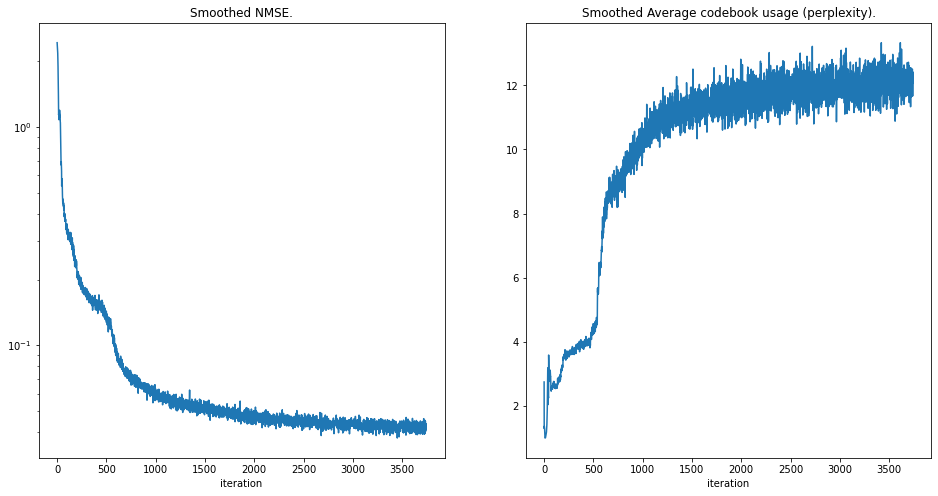

In [16]:
#source : https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=B4CzjBuPDv8m
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [17]:
model.summary()

Model: "vqvae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  19856     
_________________________________________________________________
vector_quantizer_ema (Vector multiple                  1024      
_________________________________________________________________
decoder (Decoder)            multiple                  28033     
Total params: 48,913
Trainable params: 47,889
Non-trainable params: 1,024
_________________________________________________________________


# Some results :

In [18]:
idx = np.random.choice(len(x_test_scaled), 15)
test_images = x_test_scaled[idx]


In [19]:
recon, dico_test=model.predict(test_images)


2022-03-11 14:12:53.654550: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [20]:
print(recon.max(), recon.min())

0.49682015 -0.5


In [21]:

ref_embedding=model.vectorquantizer.embedding
w = tf.transpose(ref_embedding, [1, 0])
discret_input_encoded = tf.nn.embedding_lookup(w, dico_test['encoding_indices'])

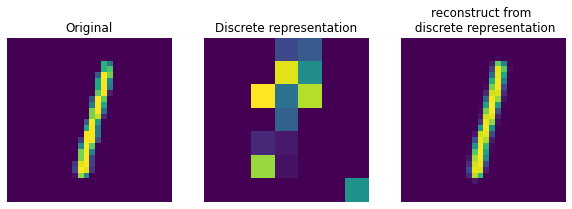

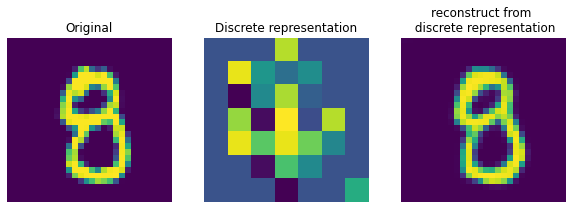

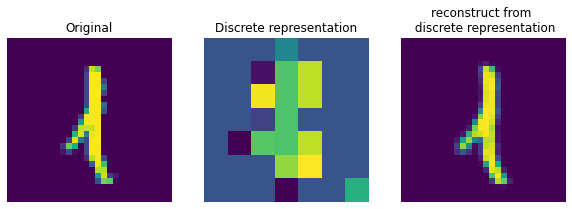

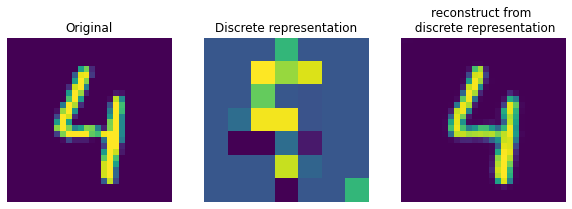

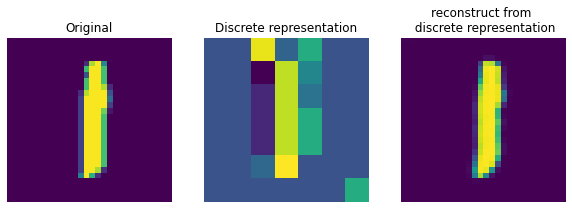

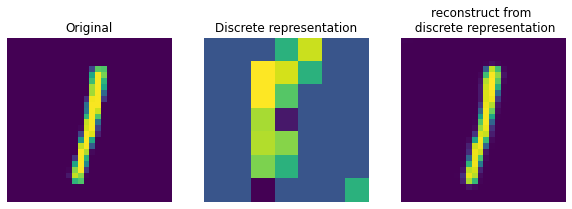

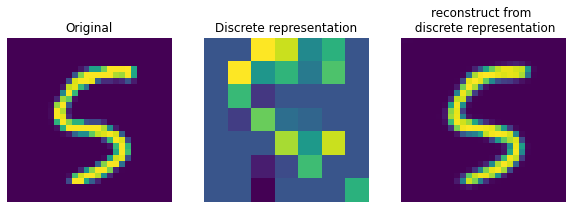

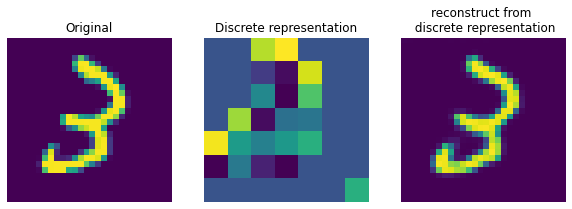

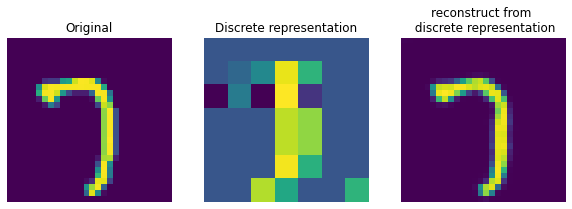

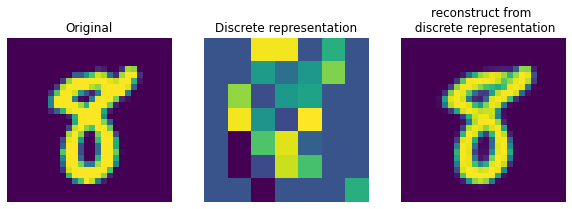

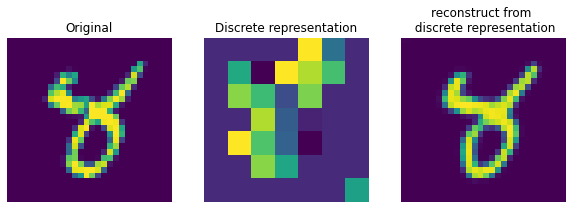

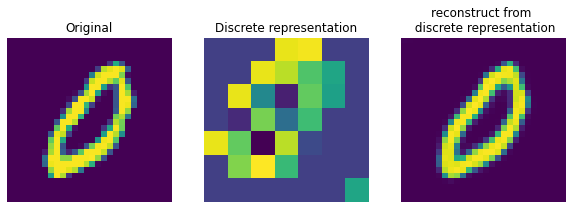

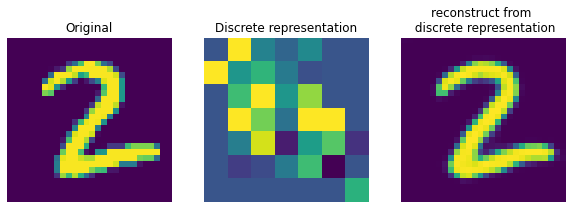

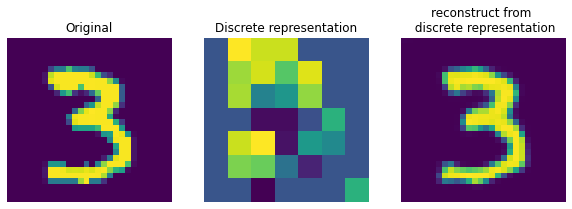

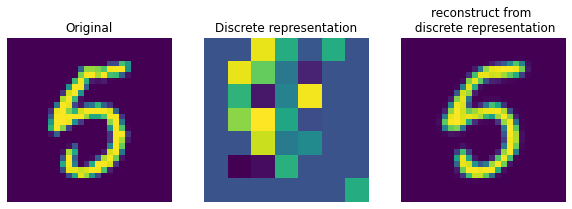

In [22]:
for i in range(len(test_images)):
    plt.figure(figsize=(10,10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(dico_test['encoding_indices'][i])
    plt.title("Discrete representation")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(model.decoder(discret_input_encoded)[i]+0.5)
    plt.title("reconstruct from \n discrete representation")
    plt.axis("off")
    

In [31]:
print((recon[0][0]==model.decoder(discret_input_encoded)[0][0]).numpy().all())
display(recon[0][0])
model.decoder(discret_input_encoded)[0][0]

False


array([[-0.48985928],
       [-0.49553177],
       [-0.49721172],
       [-0.4992857 ],
       [-0.49947235],
       [-0.49958795],
       [-0.49854794],
       [-0.4995955 ],
       [-0.49947235],
       [-0.49958795],
       [-0.49854794],
       [-0.49944407],
       [-0.49896806],
       [-0.49951482],
       [-0.49721396],
       [-0.49856937],
       [-0.49581605],
       [-0.4984616 ],
       [-0.4979442 ],
       [-0.4993544 ],
       [-0.49823695],
       [-0.49895546],
       [-0.49805108],
       [-0.49954835],
       [-0.49947235],
       [-0.49958795],
       [-0.49854794],
       [-0.49358863]], dtype=float32)

<tf.Tensor: shape=(28, 1), dtype=float32, numpy=
array([[-0.48985922],
       [-0.49553177],
       [-0.49721172],
       [-0.4992857 ],
       [-0.49947235],
       [-0.499588  ],
       [-0.49854788],
       [-0.4995956 ],
       [-0.49947235],
       [-0.499588  ],
       [-0.49854788],
       [-0.49944407],
       [-0.49896806],
       [-0.49951482],
       [-0.49721396],
       [-0.49856937],
       [-0.49581602],
       [-0.49846157],
       [-0.4979442 ],
       [-0.4993544 ],
       [-0.49823695],
       [-0.49895546],
       [-0.49805108],
       [-0.4995484 ],
       [-0.49947235],
       [-0.499588  ],
       [-0.49854788],
       [-0.49358866]], dtype=float32)>